# CHAPTER 6 Data Loading, Storage, and File Formats（数据加载，存储，文件格式）

input和output大多可以分为几类：读取文本文件或其他一些存储在磁盘上的格式，从数据库加载数据，利用web API来获取网络资源。

# 6.1 Reading and Writing Data in Text Format (以文本格式读取和写入数据)

pandas有很多用来读取表格式数据作为dataframe的函数，下面列出来一些。其中read_csv和read_tabel是最经常用到的：

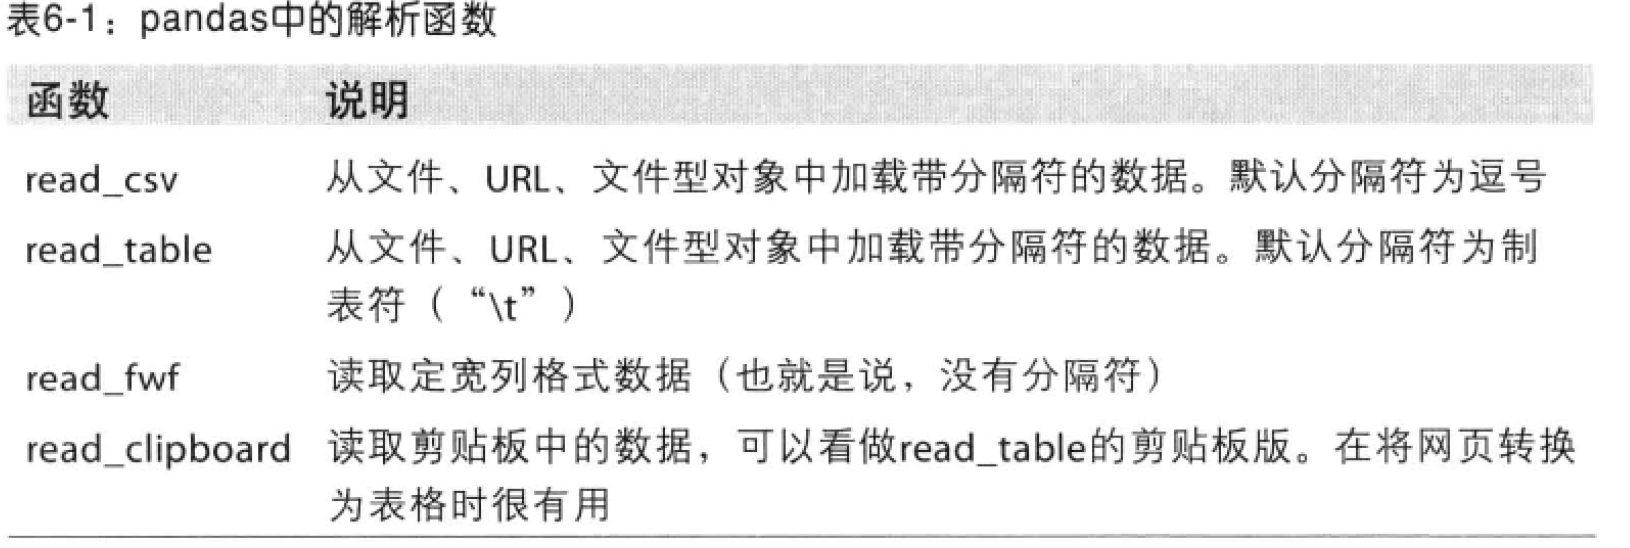

这里我们给出这些函数的大致功能，就是把test data变为dataframe。这些函数的一些可选参数有以下几类：

- Indexing（索引）

    能把返回的一列或多列作为一个dataframe。另外也可以选择从文件中获取列名或完全不获取列名
    
    
- Type inference and data conversion(类型推测和数据转换)

    这个包括用户自己定义的转换类型和缺失值转换
    
    
- Datetime parsing（日期解析）

    包含整合能力，可以把多列中的时间信息整合为一列
    
    
- Iterating（迭代）

    支持对比较大的文件进行迭代
    
    
- Unclean data issues（未清洗的数据问题）

    跳过行或柱脚，评论，或其他一些小东西，比如csv中的逗号
   
因为现实中的数据非常messy（杂乱），所以有一些数据加载函数（特别是read_csv）的轩轩也变得越来越多。对于众多参数感觉不知所措是正常的（read_csv有超过50个参数）。具体的可以去看pandas官网给出的例子。

一些函数，比如pandas.read_csv实现type inference，因为column data type不是数据类型的一种。这意味着我们没有必要指定哪些columns是数值，哪些是整数，哪些是字符串。其他一些数据格式，比如HDF5，数据类型是在格式里的。

先来一个CSV文件热热身（CSV文件指的是用逗号隔开数据的文件）：

In [2]:
!cat examples/ex1.csv

a,b,c,d,message
1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo

cat是unix下的一个shell command。如果是用windows，用type代替cat

In [3]:
import pandas as pd
import numpy as np

In [4]:
ex1_path="examples/ex1.csv"
df = pd.read_csv(ex1_path)
df

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


我们也可以用read_table来指定分隔符：

In [5]:
pd.read_table('../examples/ex1.csv', sep=',')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


一个文件不会总是有header row(页首行)，考虑下面的文件：

In [5]:
!cat examples/ex2.csv

1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo

读取这样的文件，设定column name:

In [6]:
ex2_path="examples/ex2.csv"
pd.read_csv(ex2_path, header=None)

,0,1,2,3,4
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [8]:
pd.read_csv(ex2_path, names=['a', 'b', 'c', 'd', 'message'])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


如果想要从多列从构建一个hierarchical index(阶层型索引)，传入一个包含列名的list：

In [10]:
!cat examples/csv_mindex.csv

key1,key2,value1,value2
one,a,1,2
one,b,3,4
one,c,5,6
one,d,7,8
two,a,9,10
two,b,11,12
two,c,13,14
two,d,15,16


In [11]:
parsed = pd.read_csv('examples/csv_mindex.csv',
                     index_col=['key1', 'key2'])
parsed

value1  value2
key1 key2                
one  a          1       2
     b          3       4
     c          5       6
     d          7       8
two  a          9      10
     b         11      12
     c         13      14
     d         15      16

在一些情况下，一个table可能没有固定的分隔符，用空格或其他方式来分隔。比如下面这个文件：

In [12]:
list(open('examples/ex3.txt'))

['            A         B         C\n',
 'aaa -0.264438 -1.026059 -0.619500\n',
 'bbb  0.927272  0.302904 -0.032399\n',
 'ccc -0.264273 -0.386314 -0.217601\n',
 'ddd -0.871858 -0.348382  1.100491\n']

可以看到区域是通过不同数量的空格来分隔的。这种情况下，可以传入一个正则表达式给read_table来代替分隔符。用正则表达式为`\s+`，我们得到：

In [14]:
result = pd.read_csv('examples/ex3.txt', sep='\s+')
result

,A,B,C
aaa,-0.264438,-1.026059,-0.619500
bbb,0.927272,0.302904,-0.032399
ccc,-0.264273,-0.386314,-0.217601
ddd,-0.871858,-0.348382,1.100491


因为列名比行的数量少，所以read_table推测第一列应该是dataframe的index。

这个解析器功能有很多其他参数能帮你解决遇到文件格式异常的问题（可以见之后的表格）。比如，我们要跳过第一、三、四行，使用skiprows:

In [15]:
!cat examples/ex4.csv

# hey!
a,b,c,d,message
# just wanted to make things more difficult for you
# who reads CSV files with computers, anyway?
1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo

In [16]:
pd.read_csv('examples/ex4.csv', skiprows=[0, 2, 3])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


对于缺失值，pandas使用一些sentinel value(标记值)来代表，比如NA和NULL：

In [17]:
!cat examples/ex5.csv

something,a,b,c,d,message
one,1,2,3,4,NA
two,5,6,,8,world
three,9,10,11,12,foo

In [18]:
result = pd.read_csv('examples/ex5.csv')
result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


In [17]:
pd.isnull(result)

,something,a,b,c,d,message
0,False,False,False,False,False,True
1,False,False,False,True,False,False
2,False,False,False,False,False,False


na_values选项能把我们传入的字符识别为NA，导入必须是list：

In [18]:
result = pd.read_csv('../examples/ex5.csv', na_values=['NULL'])
result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


我们还可以给不同的column设定不同的缺失值标记符，这样的话需要用到dict：

In [20]:
sentinels = {'message': ['foo', 'NA'],
             'something': ['two']}
# 把message列中的foo和NA识别为NA，把something列中的two识别为NA

pd.read_csv('../examples/ex5.csv', na_values=sentinels)

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,NaN,5,6,NaN,8,world
2,three,9,10,11.0,12,NaN


下面是pandas.read_csv和pandas.read_table中一些常用的选项：
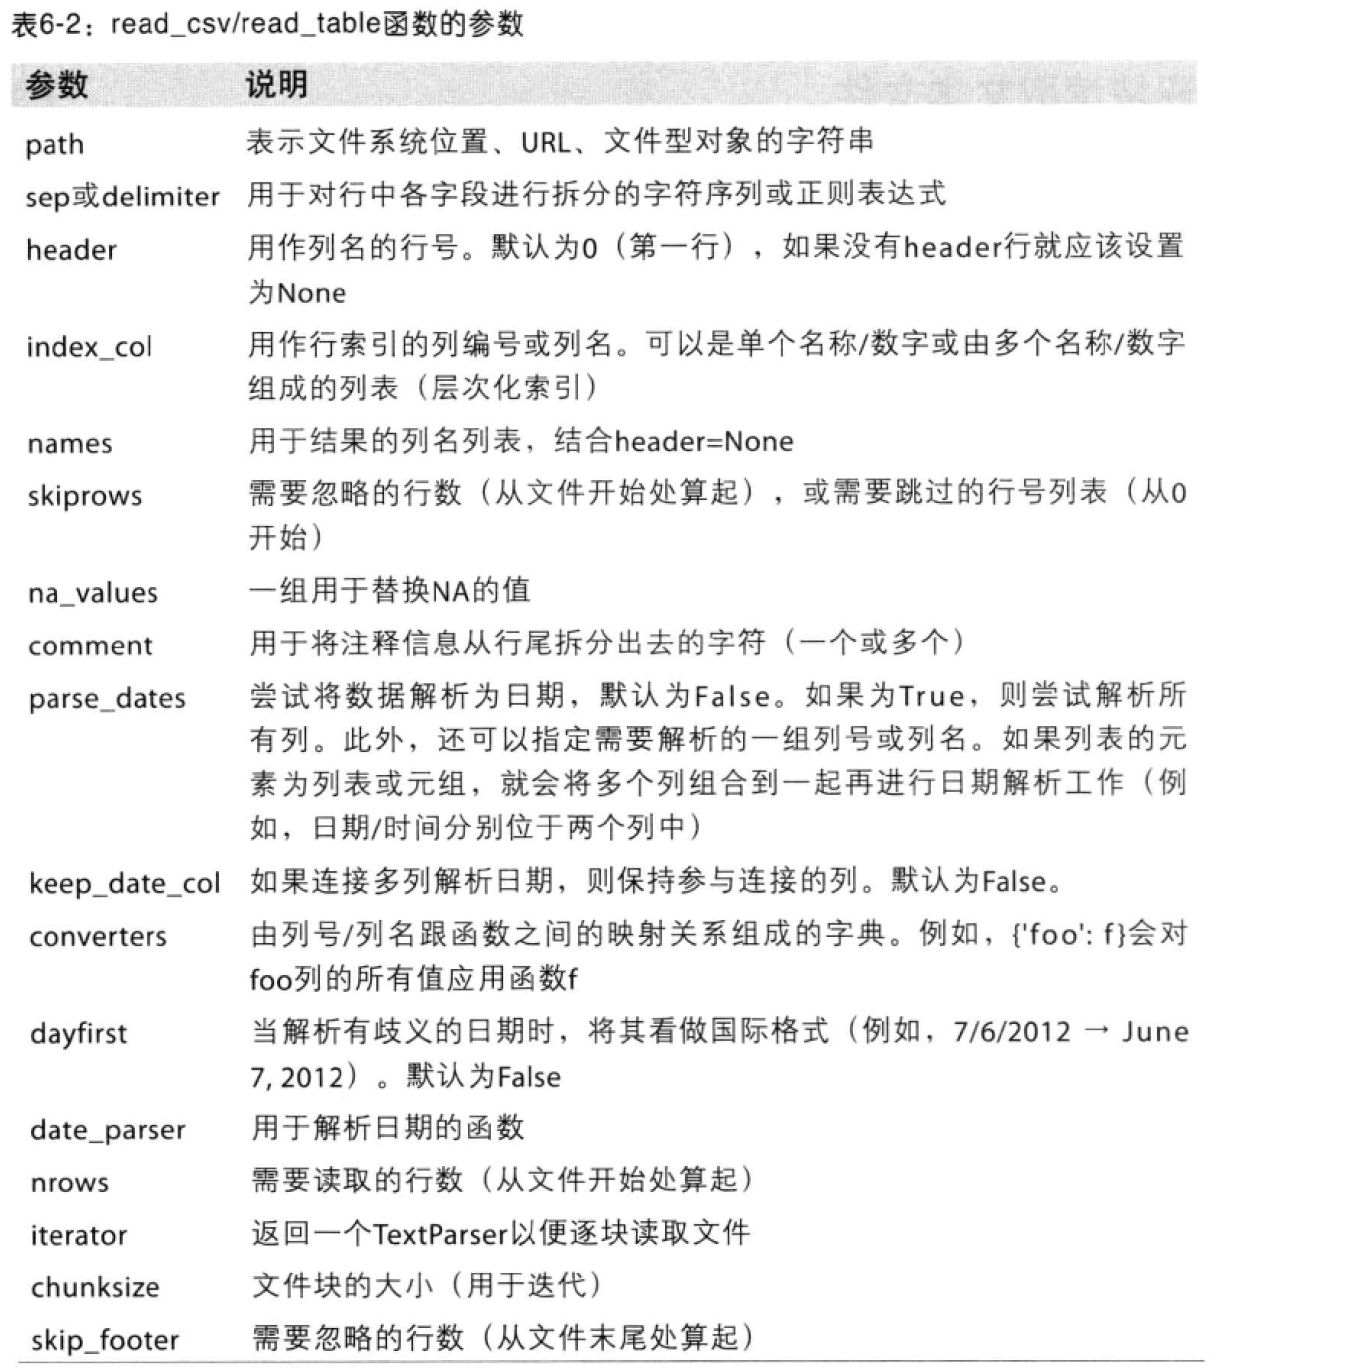
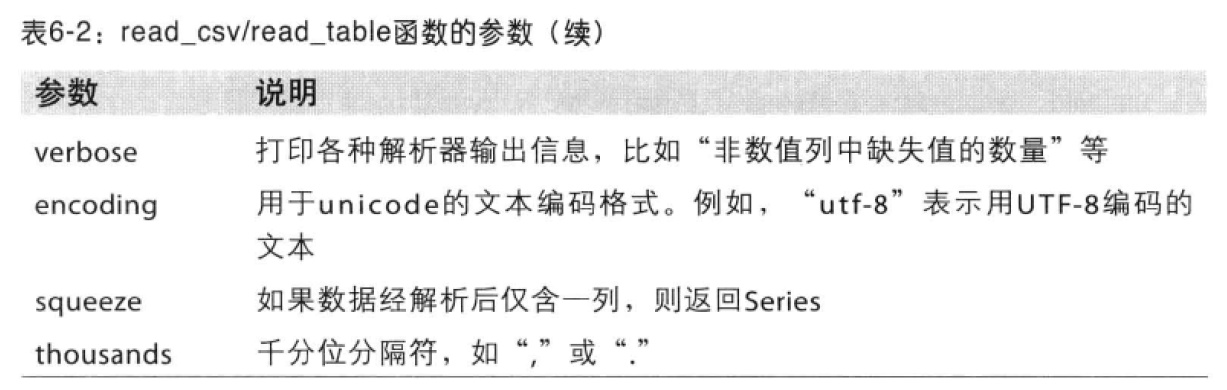

# 1 Reading Text Files in Pieces（读取一部分文本）

对于一些比较大的文件，我们想要一次读取一小部分，或者每次迭代一小部分。在我们看一个比较大的文件前，先设置一下pandas中显示的数量：

In [19]:
pd.options.display.max_rows = 10

In [20]:
result = pd.read_csv('examples/ex6.csv')
result

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q
...,...,...,...,...,...
9995,2.311896,-0.417070,-1.409599,-0.515821,L
9996,-0.479893,-0.650419,0.745152,-0.646038,E
9997,0.523331,0.787112,0.486066,1.093156,K
9998,-0.362559,0.598894,-1.843201,0.887292,G


如果只是想要读取前几行（不读取整个文件），指定一下nrows:

In [21]:
pd.read_csv('examples/ex6.csv', nrows=5)

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q


读取文件的一部分，可以指定chunksize:

In [25]:
chunker = pd.read_csv('../examples/ex6.csv', chunksize=1000)

In [26]:
chunker

pandas返回的TextParser object能让我们根据chunksize每次迭代文件的一部分。比如，我们想要迭代ex6.csv, 计算key列的值的综合：

In [22]:
ex6_path="examples/ex6.csv"
chunker = pd.read_csv(ex6_path, chunksize=1000)

tot = pd.Series([])
for piece in chunker:
    tot = tot.add(piece['key'].value_counts(), fill_value=0)
    
tot.sort_values(ascending=False)[:10]

E    368.0
X    364.0
L    346.0
O    343.0
Q    340.0
M    338.0
J    337.0
F    335.0
K    334.0
H    330.0
dtype: float64

In [23]:
chunker['key'].value_counts()[:10] # dataframe 可以直接取值

TypeError: 'TextFileReader' object is not subscriptable

TextParser有一个get_chunk方法，能返回任意大小的数据片段：

In [36]:
chunker = pd.read_csv('../examples/ex6.csv', chunksize=1000)

chunker.get_chunk(10)

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q
5,1.817480,0.742273,0.419395,-2.251035,Q
6,-0.776764,0.935518,-0.332872,-1.875641,U
7,-0.913135,1.530624,-0.572657,0.477252,K
8,0.358480,-0.497572,-0.367016,0.507702,S
9,-1.740877,-1.160417,-1.637830,2.172201,G


# 2 Writing Data to Text Format (写入数据到文本格式)

可以输出位csv格式：

In [37]:
data = pd.read_csv('../examples/ex5.csv')
data

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


In [38]:
data.to_csv('../examples/out.csv')

In [39]:
!cat ../examples/out.csv

,something,a,b,c,d,message
0,one,1,2,3.0,4,
1,two,5,6,,8,world
2,three,9,10,11.0,12,foo


其他一些分隔符也可以使用（使用sys.stdout可以直接打印文本，方便查看效果）：

In [40]:
import sys

In [41]:
data.to_csv(sys.stdout, sep='|')

|something|a|b|c|d|message
0|one|1|2|3.0|4|
1|two|5|6||8|world
2|three|9|10|11.0|12|foo


缺失值会以空字符串打印出来，我们可以自己设定缺失值的指定符：

In [42]:
data.to_csv(sys.stdout, na_rep='NULL')

,something,a,b,c,d,message
0,one,1,2,3.0,4,NULL
1,two,5,6,NULL,8,world
2,three,9,10,11.0,12,foo


如果不指定，行和列会被自动写入。当然也可以设定为不写入：

In [43]:
data.to_csv(sys.stdout, index=False, header=False)

one,1,2,3.0,4,
two,5,6,,8,world
three,9,10,11.0,12,foo


你可以指定只读取一部分列，并按你选择的顺序读取：

In [44]:
data.to_csv(sys.stdout, index=False, columns=['a', 'b', 'c'])

a,b,c
1,2,3.0
5,6,
9,10,11.0


series也有一个to_csv方法：

In [3]:
import numpy as np
import pandas as pd

In [5]:
dates = pd.date_range('1/1/2000', periods=7)

ts = pd.Series(np.arange(7), index=dates)

ts.to_csv('examples/tseries.csv',header=False)

In [6]:
!cat examples/tseries.csv

2000-01-01,0
2000-01-02,1
2000-01-03,2
2000-01-04,3
2000-01-05,4
2000-01-06,5
2000-01-07,6


# 3 Working with Delimited Formats

对于大部分磁盘中的表格型数据，用pandas.read_table就能解决。不过，有时候一些人工的处理也是需要的。

当然，有时候，一些格式不正确的行能会把read_table绊倒。为了展示一些基本用法，这里先考虑一个小的CSV文件：

In [7]:
!cat examples/ex7.csv

"a","b","c"
"1","2","3"
"1","2","3"


对于单个字符的分隔符，可以使用python内建的csv方法。只要给csv.reader一个打开的文件即可：

In [53]:
import csv
f = open('../examples/ex7.csv')
reader = csv.reader(f)

迭代这个reader:

In [55]:
for line in reader:
    print(line)

['a', 'b', 'c']
['1', '2', '3']
['1', '2', '3']


接下来，我们可以根据自己的需要来处理数据。一步步来，首先，把文件读取成一个list of lines:

In [56]:
with open('../examples/ex7.csv') as f:
    lines = list(csv.reader(f))

把lines分成header line和data lines：

In [57]:
header, values = lines[0], lines[1:]

然后我们可以用一个字典表达式来构造一个有列的字典，以及用zip(\*values)反转行为列：

In [58]:
data_dict = {h: v for h, v in zip(header, zip(*values))}
data_dict

{'a': ('1', '1'), 'b': ('2', '2'), 'c': ('3', '3')}

In [64]:
header

['a', 'b', 'c']

In [63]:
print([x for x in zip(*values)])

[('1', '1'), ('2', '2'), ('3', '3')]


CSV有很多功能。我们可以定义一个新的分隔符格式，比如字符串的引号，行结束时的回车，这里我们利用csv.Dialect来构造一个子类：

In [68]:
class my_dialect(csv.Dialect):
    lineterminator = '\n'
    delimiter = ';'
    quotechar = '"'
    quoting = csv.QUOTE_MINIMAL

f = open('../examples/ex7.csv')    
reader = csv.reader(f, dialect=my_dialect)

In [70]:
for line in reader:
    print(line)

['a,"b","c"']
['1,"2","3"']
['1,"2","3"']


当然，也可以设定一个分隔符参数给csv.reader，而不用单独定义一个子类：

In [75]:
reader = csv.reader(f, delimiter='|')

In [77]:
for line in reader:
    print(line)
    
f.close()

下面是一些csv.Dialect的选项：

![](http://oydgk2hgw.bkt.clouddn.com/pydata-book/6znl5.png)

![](http://oydgk2hgw.bkt.clouddn.com/pydata-book/phg8f.png)

对于一些更复杂的文件，比如用多种字符来做分隔符，就不能知网用csv模块来处理了。这种情况下，要先做string的split，或者用re.split

写入的话，可以用csv.write。它可以写入与csv.reader中设定一样的文件：

In [80]:
with open('../examples/mydata.csv', 'w') as f:
    writer = csv.writer(f, dialect=my_dialect)
    writer.writerow(('one', 'two', 'three'))
    writer.writerow(('1', '2', '3'))
    writer.writerow(('4', '5', '6'))
    writer.writerow(('7', '8', '9'))

In [81]:
!cat ../examples/mydata.csv 

one;two;three
1;2;3
4;5;6
7;8;9


# 4 JSON Data

JSON (short for JavaScript Object Notation)已经是发送HTTP请求的标准数据格式了。这种格式比起表个性的CSV更自由一些：

In [82]:
obj = """ 
{"name": "Wes", 
 "places_lived": ["United States", "Spain", "Germany"], 
 "pet": null, "siblings": [{"name": "Scott", "age": 30, "pets": ["Zeus", "Zuko"]}, 
                           {"name": "Katie", "age": 38, 
                            "pets": ["Sixes", "Stache", "Cisco"]}] 
} 
"""

JSON是很接近python代码的，除了他的缺失值为null和一些其他的要求。基本的类型是object(dicts), array(lists), strings, numbers, booleans, and nulls. 所以的key必须是string。有很多读取JSON的库，这里用json，它也是python内建的库。把JSON string变为python格式，用json.loads:

In [83]:
import json

In [84]:
result = json.loads(obj)
result

{'name': 'Wes',
 'pet': None,
 'places_lived': ['United States', 'Spain', 'Germany'],
 'siblings': [{'age': 30, 'name': 'Scott', 'pets': ['Zeus', 'Zuko']},
  {'age': 38, 'name': 'Katie', 'pets': ['Sixes', 'Stache', 'Cisco']}]}

使用json.dumps，可以把python object转换为JSON：

In [85]:
asjson = json.dumps(result)

如何把JSON转变为DataFrame或其他一些结构呢。可以把a list of dicts（JSON object）传给DataFrame constructor而且可以自己指定传入的部分：

In [87]:
siblings = pd.DataFrame(result['siblings'], columns=['name', 'age'])
siblings

,name,age
0,Scott,30
1,Katie,38


pandas.read_json可以自动把JSON数据转变为series或DataFrame：

In [8]:
!cat examples/example.json

[{"a": 1, "b": 2, "c": 3},
 {"a": 4, "b": 5, "c": 6},
 {"a": 7, "b": 8, "c": 9}]


pandas.read_json假设JSON数组中的每一个Object，是表格中的一行：

In [9]:
data = pd.read_json('examples/example.json')
data

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9


如果想要输出结果为JSON，用to_json方法：

In [90]:
print(data.to_json())

{"a":{"0":1,"1":4,"2":7},"b":{"0":2,"1":5,"2":8},"c":{"0":3,"1":6,"2":9}}


In [91]:
print(data.to_json(orient='records'))

[{"a":1,"b":2,"c":3},{"a":4,"b":5,"c":6},{"a":7,"b":8,"c":9}]


`orient='records'`表示输出的数据结构是 列->值 的形式：

`records : list like [{column -> value}, ... , {column -> value}]`

# 5 XML and HTML: Web Scraping (网络爬取)

python有很多包用来读取和写入HTML和XML格式。比如:lxml, Beautiful Soup, html5lib。其中lxml比较快，其他一些包则能更好的处理一些复杂的HTML和XML文件。

pandas有一个内建的函数，叫read_html, 这个函数利用lxml和Beautiful Soup这样的包来自动解析HTML，变为DataFrame。这里我们必须要先下载这些包才能使用read_html:

pandas.read_html函数有很多额外选项，但是默认会搜索并试图解析含有`<tagble>`tag的表格型数据。结果是a list of dataframe:

In [2]:
import pandas as pd
tables = pd.read_html('examples/fdic_failed_bank_list.html')

In [4]:
!cat examples/fdic_failed_bank_list.html

<!DOCTYPE html>
<!-- saved from url=(0057)https://www.fdic.gov/bank/individual/failed/banklist.html -->
<html lang="en-US"><!-- Content language is American English. --><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<title>FDIC: Failed Bank List</title>
<!-- Meta Tags -->
<meta charset="UTF-8">
<!-- Unicode character encoding -->
<meta http-equiv="X-UA-Compatible" content="IE=edge">
<!-- Turns off IE Compatiblity Mode -->
<meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1">
<!-- Makes it so phones don't auto zoom out. -->
<meta name="author" content="DRR">
<meta http-equiv="keywords" name="keywords" content="banks, financial institutions, failed, failure, closing, deposits, depositors, banking services, assuming institution, acquiring institution, claims">
<!-- CSS -->
<link rel="stylesheet" type="text/css" href="./fdic_failed_bank_list_files/responsive.css">
<link rel="stylesheet" type="text/css" href="./fdic_failed_bank_list

			  <td class="closing">January 27, 2012</td>
			  <td class="updated">December 7, 2015</td>
			  </tr><tr class="odd">
			  <td class="institution"><a href="https://www.fdic.gov/bank/individual/failed/patriot-mn.html">Patriot Bank Minnesota</a></td>
			  <td class="city">Forest Lake</td>
			  <td class="state">MN</td>
			  <td class="cert">34823</td>
			  <td class="ai">First Resource Bank</td>
			  <td class="closing">January 27, 2012</td>
			  <td class="updated">September 12, 2012</td>
			  </tr><tr class="even">
			  <td class="institution"><a href="https://www.fdic.gov/bank/individual/failed/tcb.html">Tennessee Commerce Bank</a></td>
			  <td class="city">Franklin</td>
			  <td class="state">TN</td>
			  <td class="cert">35296</td>
			  <td class="ai">Republic Bank &amp; Trust Company</td>
			  <td class="closing">January 27, 2012</td>
			  <td class="updated">March 21, 2014</td>
			  </tr><tr class="odd">
			  <td class="institution"><a href="https://www.fdic.gov/bank/individua

			  <td class="city">Spartanburg</td>
			  <td class="state">SC</td>
			  <td class="cert">35383</td>
			  <td class="ai">NAFH National Bank</td>
			  <td class="closing">July 16, 2010</td>
			  <td class="updated">March 21, 2014</td>
			  </tr><tr class="odd">
			  <td class="institution"><a href="https://www.fdic.gov/bank/individual/failed/woodlands.html">Woodlands Bank</a></td>
			  <td class="city">Bluffton</td>
			  <td class="state">SC</td>
			  <td class="cert">32571</td>
			  <td class="ai">Bank of the Ozarks</td>
			  <td class="closing">July 16, 2010</td>
			  <td class="updated">September 21, 2015</td>
			  </tr><tr class="even">
			  <td class="institution"><a href="https://www.fdic.gov/bank/individual/failed/homenatlok.html">Home National Bank</a></td>
			  <td class="city">Blackwell</td>
			  <td class="state">OK</td>
			  <td class="cert">11636</td>
			  <td class="ai">RCB Bank</td>
			  <td class="closing">July 9, 2010</td>
			  <td class="updated">December 10, 2012</t

			  <td class="closing">May 30, 2008</td>
			  <td class="updated">October 20, 2016</td>
			  </tr><tr name="hidethis" class="even">
			  <td class="institution"><a href="https://www.fdic.gov/bank/individual/failed/anb.html">ANB Financial, NA</a></td>
			  <td class="city">Bentonville</td>
			  <td class="state">AR</td>
			  <td class="cert">33901</td>
			  <td class="ai">Pulaski Bank and Trust Company</td>
			  <td class="closing">May 9, 2008</td>
			  <td class="updated">August 28, 2012</td>
			  </tr><tr name="hidethis" class="odd">
			  <td class="institution"><a href="https://www.fdic.gov/bank/individual/failed/Hume.html">Hume Bank</a></td>
			  <td class="city">Hume</td>
			  <td class="state">MO</td>
			  <td class="cert">1971</td>
			  <td class="ai">Security Bank</td>
			  <td class="closing">March 7, 2008</td>
			  <td class="updated">August 28, 2012</td>
			  </tr><tr name="hidethis" class="even">
			  <td class="institution"><a href="https://www.fdic.gov/bank/individual/fa

In [93]:
len(tables)

1

In [3]:
tables

[                                  Bank Name             City  ST   CERT  \
 0                               Allied Bank         Mulberry  AR     91   
 1              The Woodbury Banking Company         Woodbury  GA  11297   
 2                    First CornerStone Bank  King of Prussia  PA  35312   
 3                        Trust Company Bank          Memphis  TN   9956   
 4                North Milwaukee State Bank        Milwaukee  WI  20364   
 5                    Hometown National Bank         Longview  WA  35156   
 6                       The Bank of Georgia   Peachtree City  GA  35259   
 7                              Premier Bank           Denver  CO  34112   
 8                            Edgebrook Bank          Chicago  IL  57772   
 9                    Doral Bank  En Espanol         San Juan  PR  32102   
 10        Capitol City Bank & Trust Company          Atlanta  GA  33938   
 11                  Highland Community Bank          Chicago  IL  20290   
 12         

In [96]:
failures = tables[0]
failures.head()

,Bank Name,City,ST,CERT,Acquiring Institution,Closing Date,Updated Date
0,Allied Bank,Mulberry,AR,91,Today's Bank,"September 23, 2016","November 17, 2016"
1,The Woodbury Banking Company,Woodbury,GA,11297,United Bank,"August 19, 2016","November 17, 2016"
2,First CornerStone Bank,King of Prussia,PA,35312,First-Citizens Bank & Trust Company,"May 6, 2016","September 6, 2016"
3,Trust Company Bank,Memphis,TN,9956,The Bank of Fayette County,"April 29, 2016","September 6, 2016"
4,North Milwaukee State Bank,Milwaukee,WI,20364,First-Citizens Bank & Trust Company,"March 11, 2016","June 16, 2016"


这里我们做一些数据清洗和分析，比如按年计算bank failure的数量：

In [97]:
close_timestamps = pd.to_datetime(failures['Closing Date'])

In [98]:
close_timestamps.dt.year.value_counts()

2010    157
2009    140
2011     92
2012     51
2008     25
       ... 
2004      4
2001      4
2007      3
2003      3
2000      2
Name: Closing Date, dtype: int64

## Parsing XML with lxml.objectify

XML(eXtensible Markup Language)是另一种常见的数据格式，支持阶层型、嵌套的数据。这里我们演示如何用lxml来解析一个XML格式文件。

纽约都会交通局发布了巴士和地铁的时间表。每一个地跌或巴士都有一个不同的文件（比如Performance_NNR.xml对应Metro-North Railroad）:

```
<INDICATOR>
  <INDICATOR_SEQ>373889</INDICATOR_SEQ> 
  <PARENT_SEQ></PARENT_SEQ>
  <AGENCY_NAME>Metro-North Railroad</AGENCY_NAME>
  <INDICATOR_NAME>Escalator Availability</INDICATOR_NAME>
  <DESCRIPTION>Percent of the time that escalators are operational systemwide. The availability rate is based on physical observations performed the morning of regular business days only. This is a new indicator the agency began reporting in 2009.</DESCRIPTION>
  <PERIOD_YEAR>2011</PERIOD_YEAR> 
  <PERIOD_MONTH>12</PERIOD_MONTH> 
  <CATEGORY>Service Indicators</CATEGORY> 
  <FREQUENCY>M</FREQUENCY> 
  <DESIRED_CHANGE>U</DESIRED_CHANGE> 
  <INDICATOR_UNIT>%</INDICATOR_UNIT> 
  <DECIMAL_PLACES>1</DECIMAL_PLACES> 
  <YTD_TARGET>97.00</YTD_TARGET> 
  <YTD_ACTUAL></YTD_ACTUAL> 
  <MONTHLY_TARGET>97.00</MONTHLY_TARGET> 
  <MONTHLY_ACTUAL></MONTHLY_ACTUAL> 
</INDICATOR>
```

使用lxml.objectify,我们可以解析文件，通过getroot，得到一个指向XML文件中root node的指针：

In [7]:
from lxml import objectify

path = 'datasets/mta_perf/Performance_MNR.xml'
parsed = objectify.parse(open(path))
root = parsed.getroot()
root

<Element PERFORMANCE at 0x7f81f385bc48>

In [5]:
!cat datasets/mta_perf/Performance_MNR.xml

<?xml  version="1.0" encoding="ISO-8859-1"?>
<PERFORMANCE>
<INDICATOR>
  <INDICATOR_SEQ>28445</INDICATOR_SEQ>
  <PARENT_SEQ></PARENT_SEQ>
  <AGENCY_NAME>Metro-North Railroad</AGENCY_NAME>
  <INDICATOR_NAME>On-Time Performance (West of Hudson)</INDICATOR_NAME>
  <DESCRIPTION>Percent of commuter trains that arrive at their destinations within 5 minutes and 59 seconds of the scheduled time. West of Hudson services include the Pascack Valley and Port Jervis lines. Metro-North Railroad contracts with New Jersey Transit to operate service on these lines.
</DESCRIPTION>
  <PERIOD_YEAR>2008</PERIOD_YEAR>
  <PERIOD_MONTH>1</PERIOD_MONTH>
  <CATEGORY>Service Indicators</CATEGORY>
  <FREQUENCY>M</FREQUENCY>
  <DESIRED_CHANGE>U</DESIRED_CHANGE>
  <INDICATOR_UNIT>%</INDICATOR_UNIT>
  <DECIMAL_PLACES>1</DECIMAL_PLACES>
  <YTD_TARGET>95.00</YTD_TARGET>
  <YTD_ACTUAL>96.90</YTD_ACTUAL>
  <MONTHLY_TARGET>95.00</MONTHLY_TARGET>
  <MONTHLY_ACTUAL>96.90</MONTHLY_ACTUAL>
</INDICATOR>
<INDICATOR>
  <INDICAT

  <DESCRIPTION>Percent of commuter trains that arrive at their destinations within 5 minutes and 59 seconds of the scheduled time. Metro-North Railroad contracts with New Jersey Transit to operate service on the Pascack Valley Line.</DESCRIPTION>
  <PERIOD_YEAR>2010</PERIOD_YEAR>
  <PERIOD_MONTH>2</PERIOD_MONTH>
  <CATEGORY>Service Indicators</CATEGORY>
  <FREQUENCY>M</FREQUENCY>
  <DESIRED_CHANGE>U</DESIRED_CHANGE>
  <INDICATOR_UNIT>%</INDICATOR_UNIT>
  <DECIMAL_PLACES>1</DECIMAL_PLACES>
  <YTD_TARGET>97.00</YTD_TARGET>
  <YTD_ACTUAL>97.10</YTD_ACTUAL>
  <MONTHLY_TARGET>97.00</MONTHLY_TARGET>
  <MONTHLY_ACTUAL>95.20</MONTHLY_ACTUAL>
</INDICATOR>
<INDICATOR>
  <INDICATOR_SEQ>28461</INDICATOR_SEQ>
  <PARENT_SEQ>28445</PARENT_SEQ>
  <AGENCY_NAME>Metro-North Railroad</AGENCY_NAME>
  <INDICATOR_NAME>Pascack Valley Line - OTP</INDICATOR_NAME>
  <DESCRIPTION>Percent of commuter trains that arrive at their destinations within 5 minutes and 59 seconds of the scheduled time. Metro-North Railroa

  <DECIMAL_PLACES>2</DECIMAL_PLACES>
  <YTD_TARGET>2.00</YTD_TARGET>
  <YTD_ACTUAL>.19</YTD_ACTUAL>
  <MONTHLY_TARGET>2.00</MONTHLY_TARGET>
  <MONTHLY_ACTUAL>.19</MONTHLY_ACTUAL>
</INDICATOR>
<INDICATOR>
  <INDICATOR_SEQ>28627</INDICATOR_SEQ>
  <PARENT_SEQ></PARENT_SEQ>
  <AGENCY_NAME>Metro-North Railroad</AGENCY_NAME>
  <INDICATOR_NAME>Employee Lost Time and Restricted Duty Rate</INDICATOR_NAME>
  <DESCRIPTION>An employee lost time injury or illness is one that prevents an employee from returning to work for at least one full shift. The rate is injuries and illnesses per 200,000 worker hours.</DESCRIPTION>
  <PERIOD_YEAR>2008</PERIOD_YEAR>
  <PERIOD_MONTH>2</PERIOD_MONTH>
  <CATEGORY>Safety Indicators</CATEGORY>
  <FREQUENCY>M</FREQUENCY>
  <DESIRED_CHANGE>D</DESIRED_CHANGE>
  <INDICATOR_UNIT>-</INDICATOR_UNIT>
  <DECIMAL_PLACES>2</DECIMAL_PLACES>
  <YTD_TARGET>2.00</YTD_TARGET>
  <YTD_ACTUAL>.49</YTD_ACTUAL>
  <MONTHLY_TARGET>2.00</MONTHLY_TARGET>
  <MONTHLY_ACTUAL>.81</MONTHLY_ACTUA

  <DESCRIPTION>Percent of commuter trains that arrive at their destinations within 5 minutes and 59 seconds of the scheduled time.</DESCRIPTION>
  <PERIOD_YEAR>2009</PERIOD_YEAR>
  <PERIOD_MONTH>10</PERIOD_MONTH>
  <CATEGORY>Service Indicators</CATEGORY>
  <FREQUENCY>M</FREQUENCY>
  <DESIRED_CHANGE>U</DESIRED_CHANGE>
  <INDICATOR_UNIT>%</INDICATOR_UNIT>
  <DECIMAL_PLACES>1</DECIMAL_PLACES>
  <YTD_TARGET>97.90</YTD_TARGET>
  <YTD_ACTUAL>97.90</YTD_ACTUAL>
  <MONTHLY_TARGET>97.90</MONTHLY_TARGET>
  <MONTHLY_ACTUAL>98.10</MONTHLY_ACTUAL>
</INDICATOR>
<INDICATOR>
  <INDICATOR_SEQ>28345</INDICATOR_SEQ>
  <PARENT_SEQ>55526</PARENT_SEQ>
  <AGENCY_NAME>Metro-North Railroad</AGENCY_NAME>
  <INDICATOR_NAME>Hudson Line - OTP</INDICATOR_NAME>
  <DESCRIPTION>Percent of commuter trains that arrive at their destinations within 5 minutes and 59 seconds of the scheduled time.</DESCRIPTION>
  <PERIOD_YEAR>2009</PERIOD_YEAR>
  <PERIOD_MONTH>11</PERIOD_MONTH>
  <CATEGORY>Service Indicators</CATEGORY>
  <F

  <CATEGORY>Service Indicators</CATEGORY>
  <FREQUENCY>M</FREQUENCY>
  <DESIRED_CHANGE>U</DESIRED_CHANGE>
  <INDICATOR_UNIT>%</INDICATOR_UNIT>
  <DECIMAL_PLACES>1</DECIMAL_PLACES>
  <YTD_TARGET>97.70</YTD_TARGET>
  <YTD_ACTUAL>98.10</YTD_ACTUAL>
  <MONTHLY_TARGET>97.70</MONTHLY_TARGET>
  <MONTHLY_ACTUAL>97.70</MONTHLY_ACTUAL>
</INDICATOR>
<INDICATOR>
  <INDICATOR_SEQ>55526</INDICATOR_SEQ>
  <PARENT_SEQ></PARENT_SEQ>
  <AGENCY_NAME>Metro-North Railroad</AGENCY_NAME>
  <INDICATOR_NAME>On-Time Performance (East of Hudson)</INDICATOR_NAME>
  <DESCRIPTION>Percent of commuter trains that arrive at their destinations within 5 minutes and 59 seconds of the scheduled time. East of Hudson service includes the Harlem, Hudson and New Haven lines.</DESCRIPTION>
  <PERIOD_YEAR>2010</PERIOD_YEAR>
  <PERIOD_MONTH>3</PERIOD_MONTH>
  <CATEGORY>Service Indicators</CATEGORY>
  <FREQUENCY>M</FREQUENCY>
  <DESIRED_CHANGE>U</DESIRED_CHANGE>
  <INDICATOR_UNIT>%</INDICATOR_UNIT>
  <DECIMAL_PLACES>1</DECIMAL_PL

root.INDICATOR 返回一个生成器，每次调用能生成一个`<INDICATOR>`XML元素。每一个记录，我们产生一个dict，tag name(比如YTD_ACTUAL)作为字典的key：

In [101]:
data = []

skip_fields = ['PARENT_SEQ', 'INDICATOR_SEQ', 
               'DESIRED_CHANGE', 'DECIMAL_PLACES']

for elt in root.INDICATOR:
    el_data = {}
    for child in elt.getchildren():
        if child.tag in skip_fields:
            continue
        el_data[child.tag] = child.pyval
    data.append(el_data)

然后我们把这个dict变为DataFrame：

In [102]:
perf = pd.DataFrame(data)
perf.head()

,AGENCY_NAME,CATEGORY,DESCRIPTION,FREQUENCY,INDICATOR_NAME,INDICATOR_UNIT,MONTHLY_ACTUAL,MONTHLY_TARGET,PERIOD_MONTH,PERIOD_YEAR,YTD_ACTUAL,YTD_TARGET
0,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,96.9,95,1,2008,96.9,95
1,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,95,95,2,2008,96,95
2,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,96.9,95,3,2008,96.3,95
3,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,98.3,95,4,2008,96.8,95
4,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,95.8,95,5,2008,96.6,95


XML数据能得到比这个例子更复杂的情况。每个tag都有数据。比如一个而HTML链接，也是一个有效的XML：

In [8]:
from io import StringIO
tag = '<a href="http://www.google.com">Google</a>'
root = objectify.parse(StringIO(tag)).getroot()

我们可以访问任何区域的tag(比如href)：

In [104]:
root

<Element a at 0x114860948>

In [105]:
root.get('href')

'http://www.google.com'

In [9]:
root.text

'Google'

# 6.2 Binary Data Formats (二进制数据格式)

最简单的以二进制的格式来存储数据的方法（也被叫做serialization，序列化），就是用python内建的pickle。所有的pandas object都有一个to_pickle方法，可以用来存储数据为pickle格式：

In [1]:
import pandas as pd
import numpy as np

In [2]:
frame = pd.read_csv('../examples/ex1.csv')
frame

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [3]:
frame.to_pickle('../examples/frame_pickle')

In [4]:
!ls ../examples/

array_archive.npz          macrodata.csv
array_compressed.npz       mydata.csv
array_ex.txt               out.csv
csv_mindex.csv             segismundo.txt
ex1.csv                    sink.txt
ex1.xlsx                   some_array.npy
ex2.csv                    spx.csv
ex3.csv                    stinkbug.png
ex3.txt                    stock_px.csv
ex4.csv                    stock_px_2.csv
ex5.csv                    test_file.csv
ex6.csv                    tips.csv
ex7.csv                    tmp.txt
example.json               tseries.csv
fdic_failed_bank_list.html volume.csv
frame_pickle               yahoo_price.pkl
ipython_bug.py             yahoo_volume.pkl


用内建的pickle可以直接读取任何pickle文件，或者直接用pandas.read_pickle:

In [5]:
pd.read_pickle('../examples/frame_pickle')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


注意：pickle只推荐用于短期存储。因为这种格式无法保证长期稳定；比如今天pickled的一个文件，可能在库文件更新后无法读取。

python还支持另外两种二进制数据格式：HDF5和MessagePack。下面会介绍一个HDF5，但是我们鼓励你多尝试一个不同的文件格式，看看他们能有多快，是否符合你数据分析的要求。另外一些可用的存储格式有：bcolz 和 Feather。

# 1 Using HDF5 Format

HDF5格式是用来存储大量的科学数组数据的。这种格式还能用于其他一些语言。其中HDF表示hierarchical data format。每一个HDF5格式能春初多个数据集，并支持metadata。

> 元数据(meta data)——“data about data” 关于数据的数据，一般是结构化数据（如存储在数据库里的数据，规定了字段的长度、类型等）。元数据是指从信息资源中抽取出来的用于说明其特征、内容的结构化的数据(如题名,版本、出版数据、相关说明,包括检索点等)，用于组织、描述、检索、保存、管理信息和知识资源。

HDF5 支持多种压缩模式的on-the-fly compression（即时压缩），能让数据中一些重复的部分存储地更有效。HDF5对于处理大数据集是一个很好的选择，因为他不会把所有数据一次性读取到内存里，我们可以从很大的数组中有效率地读取一小部分。

能用PyTables或h5py来访问HDF5数据，pandas也有提供一个high-level的交互界面。HDFStore类像dict一样能用来处理low-level细节：


In [13]:
frame = pd.DataFrame({'a': np.random.randn(100)})

store = pd.HDFStore('../examples/mydata.h5')

In [10]:
frame.head()

,a
0,0.908968
1,-0.589368
2,0.015493
3,0.029850
4,1.682180


In [14]:
cat ../examples/mydata.csv

one;two;three
1;2;3
4;5;6
7;8;9


In [8]:
store['obj1'] = frame

store['obj1_col'] = frame['a']

store

<class 'pandas.io.pytables.HDFStore'>
File path: ../examples/mydata.h5
/obj1                frame        (shape->[100,1])
/obj1_col            series       (shape->[100])  

HDF5中的object能用像dict一样的API来提取：

In [12]:
store['obj1']

,a
0,0.908968
1,-0.589368
2,0.015493
3,0.029850
4,1.682180
5,-0.977549
6,0.806008
7,-0.458852
8,-0.833007
9,0.410430


HDFStore支持两种存储架构，fixed和table。后者通常更慢一些，但支持查询操作：

In [15]:
store.put('obj2', frame, format='table')

In [16]:
store.select('obj2', where=['index >= 10 and index <= 15'])

,a
10,-1.186667
11,0.628998
12,-0.668921
13,0.775731
14,-1.329899
15,1.920832


put是存储的另一种写法，类似于之前的`store['obj2'] = frame`，但这种协防能让我们设置存储格式。

pandas.read_hdf函数也很方便：

In [19]:
frame.to_hdf('../examples/mydata.h5', 'obj3', format='table')

In [20]:
pd.read_hdf('../examples/mydata.h5', 'obj3', where=['index < 5'])

,a
0,1.324210
1,0.770813
2,0.554799
3,-1.741867
4,-1.875071


注意：如果我们是把数据存在远端服务器上，比如Amazon S3或HDFS，使用一些为分布式存储实际的二进制格式会更适合一些，比如Apache Parquet。

如果是在本地处理很大数据量的话，推荐尝试PyTables和h5py看是否符合你的要求。因为很多数据分析问题都受限于I/O，所以用HDF5这样的工具能加快应用。

注意：HDF5不是数据库（database）。它最适合一次写入，多次读取的数据库。尽管数据可以在任何时间多次写入一个文件，如果多个使用者同时写入的话，文件会被破坏。

# 2 Reading Microsoft Excel Files（读取微软的excel文件）

pandas支持读取表格型数据（excel 2003或更高）文件，使用ExcelFile class或pandas.read_excel函数。这些工具需要一些富家的包xlrd和openpyxl来分别读取XLS和XLSX文件。你可以通过pip或conda来安装。

使用ExcelFile，创建一个instance，通过给xls或xlsx一个路径：

In [21]:
xlsx = pd.ExcelFile('../examples/ex1.xlsx')

保存在sheet里的数据，可以通过parse来读取为DataFrame：

In [22]:
pd.read_excel(xlsx, 'Sheet1')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


如果要读取一个文件中的多个sheet，用ExcelFile会更快。当然，你也能把文件名直接传递给pandas.read_excel:

In [23]:
frame = pd.read_excel('../examples/ex1.xlsx', 'Sheet1')
frame

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


如果要把pandas数据写为Excel格式，你必须先创建一个ExcelWrite，然后用to_excel方法：

In [24]:
writer = pd.ExcelWriter('../examples/ex2.xlsx')

In [26]:
frame.to_excel(writer, 'Sheet1')

In [27]:
writer.save()

如果不使用ExcelWriter的话，可以直接传给to_excel一个path：

In [28]:
frame.to_excel('../examples/ex2.xlsx')

# 6.3 Interacting with Web APIs (网络相关的API交互)

很多网站都有公开的API，通过JSON等格式提供数据流。有很多方法可以访问这些API，这里推荐一个易用的requests包。

找到github里pandas最新的30个issues，制作一个GET HTTP request, 通过使用requests包：

In [8]:
import pandas as pd
import numpy as np

In [10]:
import requests

In [13]:
url = 'https://api.github.com/repos/pandas-dev/pandas/issues'
resp = requests.get(url)
resp

<Response [200]>

response的json方法能返回一个dict，包含可以解析为python object的JSON：

In [5]:
data = resp.json()
data[0]['title']

'Optimize data type'

In [9]:
data[0]

{'assignee': None,
 'assignees': [],
 'author_association': 'NONE',
 'body': 'Hi guys, i\'m user of mysql\r\nwe have an "function" PROCEDURE ANALYSE\r\nhttps://dev.mysql.com/doc/refman/5.5/en/procedure-analyse.html\r\n\r\nit get all "dataframe" and show what\'s the best "dtype", could we do something like it in Pandas?\r\n\r\nthanks!',
 'closed_at': None,
 'comments': 1,
 'comments_url': 'https://api.github.com/repos/pandas-dev/pandas/issues/18272/comments',
 'created_at': '2017-11-13T22:51:32Z',
 'events_url': 'https://api.github.com/repos/pandas-dev/pandas/issues/18272/events',
 'html_url': 'https://github.com/pandas-dev/pandas/issues/18272',
 'id': 273606786,
 'labels': [],
 'labels_url': 'https://api.github.com/repos/pandas-dev/pandas/issues/18272/labels{/name}',
 'locked': False,
 'milestone': None,
 'number': 18272,
 'repository_url': 'https://api.github.com/repos/pandas-dev/pandas',
 'state': 'open',
 'title': 'Optimize data type',
 'updated_at': '2017-11-13T22:57:27Z',
 'url': 

data中的每一个元素都是一个dict，这个dict就是在github上找到的issue页面上的信息。我们可以把data传给DataFrame并提取感兴趣的部分：

In [11]:
issues = pd.DataFrame(data, columns=['number', 'title', 
                                    'labels', 'state'])
issues

,number,title,labels,state
0,18272,Optimize data type,[],open
1,18271,BUG: Series.rank(pct=True).max() != 1 for a la...,[],open
2,18270,(Series|DataFrame) datetimelike ops,[],open
3,18268,DOC: update Series.combine/DataFrame.combine d...,[],open
4,18266,DOC: updated .combine_first doc strings,[{'url': 'https://api.github.com/repos/pandas-...,open
5,18265,Calling DataFrame.stack on an out-of-order col...,[],open
6,18264,cleaned up imports,[{'url': 'https://api.github.com/repos/pandas-...,open
7,18263,Tslibs offsets paramd,[],open
8,18262,DEPR: let's deprecate,[{'url': 'https://api.github.com/repos/pandas-...,open
9,18258,DEPR: deprecate (Sparse)Series.from_array,[{'url': 'https://api.github.com/repos/pandas-...,open


通过一些体力活，我们可以构建一些高层级的界面，让web API直接返回DataFrame格式，以便于分析。

# 6.4 Interacting with Databases(与数据库的交互)

如果在工作中，大部分数据并不会以text或excel的格式存储。最广泛使用的是SQL-based的关系型数据库（SQL Server，PostgreSQL，MySQL）。选择数据库通常取决于性能，数据整合性，实际应用的可扩展性。

读取SQL到DataFrame非常直观，pandas中有一些函数能简化这个过程。举个例子，这里创建一个SQLite数据库，通过使用python内建的sqlite3 driver：

In [14]:
import sqlite3
import pandas as pd

In [2]:
query = """
CREATE TABLE test
(a VARCHAR(20), b VARCHAR(20),
 c REAL,        d INTEGER
);"""

In [4]:
con = sqlite3.connect('../examples/mydata.sqlite')

In [5]:
con.execute(query)

In [6]:
con.commit()

然后我们插入几行数据：

In [7]:
data = [('Atlanta', 'Georgia', 1.25, 6),
        ('Tallahassee', 'Florida', 2.6, 3),
        ('Sacramento', 'California', 1.7, 5)]

In [8]:
stmt = "INSERT INTO test VALUES(?, ?, ?, ?)"

In [9]:
con.executemany(stmt, data)

In [10]:
con.commit()

大部分python的SQL驱动(PyODBC, psycopg2, MySQLdb, pymssql, 等)返回a list of tuple，当从一个表格选择数据的时候：

In [11]:
cursor = con.execute('select * from test')

In [12]:
rows = cursor.fetchall()

In [13]:
rows

[('Atlanta', 'Georgia', 1.25, 6),
 ('Tallahassee', 'Florida', 2.6, 3),
 ('Sacramento', 'California', 1.7, 5)]

我们可以把list of tuples传递给DataFrame，但是我们也需要column names,包含cursor的description属性：

In [14]:
cursor.description

(('a', None, None, None, None, None, None),
 ('b', None, None, None, None, None, None),
 ('c', None, None, None, None, None, None),
 ('d', None, None, None, None, None, None))

In [16]:
pd.DataFrame(rows, columns=[x[0] for x in cursor.description])

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5


我们不希望每次询问数据库的时候都重复以上步骤，这样对计算机很不好(mung,【计】逐步对计算机系统或文件做小改动导致大的损害)。SQLAlchemy计划是一个六星的Python SQL工具箱，它能抽象出不同SQL数据库之间的不同。pandas有一个read_sql函数，能让我们从SQLAlchemy connection从读取数据。这里我们用SQLAlchemy连接到同一个SQLite数据库，并从之前创建的表格读取数据：

In [15]:
import sqlalchemy as sqla

ModuleNotFoundError: No module named 'sqlalchemy'

In [21]:
db = sqla.create_engine('sqlite:///../examples/mydata.sqlite')

In [22]:
pd.read_sql('select * from test', db)

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5
